In [1]:
import csv
import numpy as np
import tensorflow as tf

np.random.seed(5)

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

class MyData:
    def __init__(self, num_train=None):
        self.num_train = num_train
        self.testdata = []
        self.traindata = []
        self.trainlabel = []
        with open('test.data.csv', 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                self.testdata.append(row)
        with open('train.data.csv', 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                self.traindata.append(row)
        with open('train.labels.csv', 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                self.trainlabel.append(row)
                
        self.testdt = np.array(self.testdata[1:], dtype=float)        
        if self.num_train != None:
            self.traindt = np.array(self.traindata[1:self.num_train+1], dtype=float)
            self.trainlb = convert_to_one_hot(np.array(self.trainlabel[1:self.num_train+1], dtype=int).flatten(), 2)
            self.devdt = np.array(self.traindata[self.num_train+1:], dtype=float)
            self.devlbflat = np.array(self.trainlabel[self.num_train+1:], dtype=int).flatten()
            self.devlb = convert_to_one_hot(np.array(self.trainlabel[self.num_train+1:], dtype=int).flatten(), 2)
        else:
            self.traindt = np.array(self.traindata[1:], dtype=float)
            self.trainlb = convert_to_one_hot(np.array(self.trainlabel[1:], dtype=int).flatten(), 2)
            self.devdt = None
            self.devlb = None
        
        self.shuffled_idx = np.arange(len(self.trainlb))
        np.random.shuffle(self.shuffled_idx)
        self.idx = 0

    def next_batch(self, batch_size=128):
        # just drop the rest data... I do not care...
        if self.idx + batch_size >= len(self.trainlb):
            np.random.shuffle(self.shuffled_idx)
            self.idx = 0
        
        res = (self.traindt[self.shuffled_idx[self.idx:self.idx + batch_size]],
               self.trainlb[self.shuffled_idx[self.idx:self.idx + batch_size]])
        self.idx += batch_size
        return res
    
    def get_dev(self):
        return (self.devdt, self.devlb)
    
    def get_test(self):
        return self.testdt
    
    def get_all(self):
        return (np.array(self.traindata[1:], dtype=float), np.array(self.trainlabel[1:], dtype=int).flatten())
    
mydata = MyData(12000)
DIM = mydata.traindt.shape[1]
CLASS = len(np.unique(mydata.trainlb))
#print(mydata.next_batch())

/home/andi/.conda/envs/pml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# tf parameters
learning_rate = 0.003
num_steps = 30000

# tf Graph input
X = tf.placeholder("float", [None, DIM])
Y = tf.placeholder("float", [None, CLASS])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([DIM, 2*DIM])),
    'h2': tf.Variable(tf.random_normal([2*DIM, 2*DIM])),
    'h3': tf.Variable(tf.random_normal([2*DIM, 2*DIM])),
    'out': tf.Variable(tf.random_normal([2*DIM, CLASS]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([2*DIM])),
    'b2': tf.Variable(tf.random_normal([2*DIM])),
    'b3': tf.Variable(tf.random_normal([2*DIM])),
    'out': tf.Variable(tf.random_normal([CLASS]))
}

# Create model
def neural_net(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']))
    out_layer = tf.matmul(layer_3, weights['out'] + biases['out'])
    return (out_layer, layer_3)

# Construct model
logits, feature = neural_net(X)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [3]:
display_step = 1000
dev_step = 1000

dev_x, dev_y = mydata.get_dev()
all_x, all_y = mydata.get_all()
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = mydata.next_batch()
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
        if step % dev_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: dev_x,
                                                                 Y: dev_y})
            print("Step " + str(step) + ", dev Loss= " + \
                  "{:.4f}".format(loss) + ", dev Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")
    
    features = sess.run(feature, feed_dict = {X: all_x})
    features_test = sess.run(feature, feed_dict = {X: mydata.testdt})
    predict_prob = sess.run(prediction, feed_dict = {X: mydata.get_test()})

Step 1, Minibatch Loss= 46.2939, Training Accuracy= 0.516
Step 1, dev Loss= 48.5092, dev Accuracy= 0.492
Step 1000, Minibatch Loss= 0.1490, Training Accuracy= 0.938
Step 1000, dev Loss= 0.3128, dev Accuracy= 0.900
Step 2000, Minibatch Loss= 0.0248, Training Accuracy= 0.992
Step 2000, dev Loss= 0.2166, dev Accuracy= 0.930
Step 3000, Minibatch Loss= 0.0291, Training Accuracy= 0.977
Step 3000, dev Loss= 0.1724, dev Accuracy= 0.948
Step 4000, Minibatch Loss= 0.0168, Training Accuracy= 1.000
Step 4000, dev Loss= 0.1654, dev Accuracy= 0.954
Step 5000, Minibatch Loss= 0.0171, Training Accuracy= 1.000
Step 5000, dev Loss= 0.1496, dev Accuracy= 0.960
Step 6000, Minibatch Loss= 0.0345, Training Accuracy= 0.984
Step 6000, dev Loss= 0.1692, dev Accuracy= 0.958
Step 7000, Minibatch Loss= 0.0032, Training Accuracy= 1.000
Step 7000, dev Loss= 0.1531, dev Accuracy= 0.962
Step 8000, Minibatch Loss= 0.0203, Training Accuracy= 0.992
Step 8000, dev Loss= 0.1924, dev Accuracy= 0.957
Step 9000, Minibatch Lo

In [4]:
prob_1 = predict_prob[:, 1]
f = open("test.nnpredict.csv", "w")
f.write("ID,ProbFemale\n")
for i in range(len(prob_1)):
    f.write(str(i+1) + "," + str(prob_1[i]) + "\n")
f.close()

import pickle
pickle.dump(features, open("nntrain.pkl", "wb"))
pickle.dump(features_test, open("nntest.pkl", "wb"))

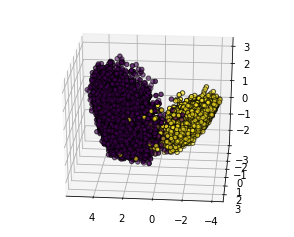

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
#%matplotlib notebook
%matplotlib inline

X = features
y = all_y

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=27, azim=95)

plt.cla()
pca = PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,
           edgecolor='k')

plt.show()
fig.savefig(os.path.join('./', 'nnfeatures.pdf'), format="pdf", dpi=600)